## Eigenvalue/eigenfunction Analysis

We have computed (an approximation to) the eigenvalues and eigenfunctions of
$$ \int_{\Omega} \nabla u \cdot \nabla \phi - u\phi \ \mathrm{d}x = 0,$$
which are saved to `.npz` files. 
We now want to read in these eigenvalues and eigenvectors to examine the behaviour of the "right-most" eigenvalue/function in the first band of the spectrum.

This notebook contains a record of the necessary programs and methods for extracting eigenvalues from the file stores, inferring the values of $N$ and the number of eigenvalues computed, and plotting the stored solutions via `matplotlib`.

### Requirements:
- fenicsproject environment is active
- Eigenvalues and eigenvectors are saved to files in the directory `./EvalDump/`.

### Outputs:
NB: Finding the "right-most" eigenvalue of the first band is difficult, for reasons that can be seen when plotting the distribution of eigenvalues.
- Function plot of the "left-most" eigenvalue's eigenfunction
- Histogram displaying the distribution of found eigenvalues

In [1]:
from fenics import *
from dolfin import *

import numpy as np

import scipy.sparse as spSparse
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

%matplotlib inline

import glob

In [2]:
# This is the name of our mesh files, minus the extension.
filePrefix = 'FEM_CrossGraphSetup'
# This is the gmsh file which generated our domain's mesh. We can infer information about our domain from it
gmshFile = filePrefix + '.geo'
# This is the folder into which we will place our stiffness matrices, once they are assembled
matDumpFolder = 'StiffnessMatrixDump'
evalDumpFolder = 'EvalDump'

# Deduce value of N from gmshFile - it appears on line 12,
# with the 5th character being (the start of) the value of N.
with open('FEM_CrossGraphSetup.geo') as fp:
    for i, line in enumerate(fp):
        if i == 11:
            # 11th line
            Nstr = line[4:-2] #take all characters after the numerical value appears in the file
        elif i > 11:
            #terminate loop early
            break
# We want N as a float because we will use it in computations, to define points on meshes etc. Int might cause bugs.
for i, char in enumerate(Nstr):
    if char==';':
        Nstr = Nstr[:i]
        break
N = float(Nstr)

In [3]:
# Create a subclass for the 2D-periodic domain...
class PeriodicDomain(SubDomain):
    #map left--> right and bottom-->top

    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], N)) or
                        (near(x[0], N) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], N) and near(x[1], N):
            y[0] = x[0] - N
            y[1] = x[1] - N
        elif near(x[0], N):
            y[0] = x[0] - N
            y[1] = x[1]
        else:   # near(x[1], N)
            y[0] = x[0]
            y[1] = x[1] - N
#concludes the SubDomain subclass definition

# Now we import our mesh...
meshFile = filePrefix + '.xml'
mesh = Mesh(meshFile)

# To plot functions, we need to know the function space we are working with, which we obtain from the mesh
# Although the data for the eigenvectors is stored in wVecs, in order to correctly plot it and assign values at
# each node in the mesh, we need the topographical data from the mesh and the function space we are using
V = FunctionSpace(mesh, 'CG', 1, constrained_domain=PeriodicDomain())

In [4]:
# Infer filenames via naming convention
fA1 = './' + matDumpFolder + '/a1_N' + Nstr + '.npz'
fA2 = './' + matDumpFolder + '/a2_N' + Nstr + '.npz'
# Infer filenames storing evals and evecs
# These files also have a further number after them, encoding the number of e'vals and e'vecs they store,
# so we need to infer this too before we can load the files.
preAppend = './' + evalDumpFolder + '/evals-N' + Nstr
evalFileMatches = glob.glob(preAppend + '*.npy')
# This is a list of all the candidate files, which we have generated that contain eigenvalues and eigenvectors
# Each element is a string containing a path to a file, of the form
# preAppend + '-xxx.npy',
# where xxx is an int which matches the number of eigenvalues stored in the file.
# We will extract the largest of these values, and open the files which contain the most eigenvalues and
# eigenvectors.
if len(evalFileMatches)==1:
    # Precisely one file matches, this must be the file we need
    # Now extract the number 'xxx' from the filename via slicing...
    nVals = int(evalFileMatches[0][len(preAppend)+1:-4])
elif not evalFileMatches:
    # An empty list, by default, evaluates to false in bool operations.
    # If we get to here, we didn't find any stored eigenvalues, so raise an error
    raise OSError('No eigenvalue files found for N=%d, using search string %s' % (N, preAppend+'*.npy'))
else:
    # Multiple matching files, we now search for the one with the largest number of eigenvalues stored in it
    maxInd = 0
    nVals = 0
    for i,fname in enumerate(evalFileMatches):
        n = int(fname[len(preAppend)+1:-4])
        if n > nVals:
            # This file contains more eigenvalues than our current maximum
            maxInd = i
            nVals = n
# nVals now contains the (largest) number of eigenvalues stored for this value of N,
# we can now load the eval and evec files.
eValsF = preAppend + '-' + str(nVals) + '.npy'
eVecsF = './' + evalDumpFolder + '/evecs-N' + Nstr + '-' + str(nVals) + '.npy'
print('Loading files %s (evals) and %s (evecs) for N=%d' % (eValsF, eVecsF, N))

wVals = np.load(eValsF)
wVecs = np.load(eVecsF)

Loading files ./EvalDump/evals-N3-143.npy (evals) and ./EvalDump/evecs-N3-143.npy (evecs) for N=3


Running the cells above results in us importing the eigenvalues and eigenvectors for the current value of $N$, as deduced from the `.geo` file (see `Assemble_Stiffness_Matrices` documentation for details).

Now, we can create plots and examine the available information from these values and vectors.

/home/will/anaconda3/envs/fenicsproject/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


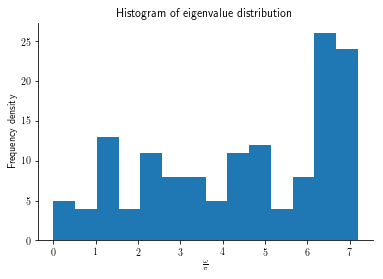

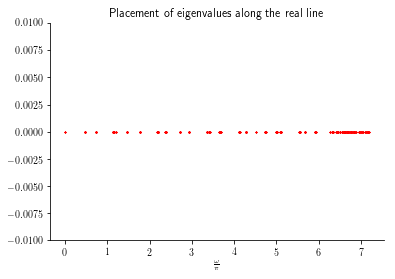

In [5]:
def FigWindowSettings(axis):
    '''
    Changes a matplotlib.pyplot axis object to have no top and right border or tick marks.
    INPUTS:
        axis: matplotlib.pyplot axis object
    '''

    # Hide the right and top spines
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axis.yaxis.set_ticks_position('left')
    axis.xaxis.set_ticks_position('bottom')
    return

# Create a histogram showing the distribution of the eigenvalues.
# For ease, we will normalised the eigenvalues by pi.
fig, ax = plt.subplots(1)
FigWindowSettings(ax)
ax.hist(wVals / np.pi, bins = int(nVals/10))
ax.set_xlabel(r'$\frac{\omega}{\pi}$')
ax.set_ylabel(r'Frequency density')
ax.set_title(r'Histogram of eigenvalue distribution')
fig.show()

# The histogram might be a bit crowded and also removes the ability to see relative distance 
# between the e'vals though, we can use a scatter plot of the eigenvalues to recover this.
fig, ax = plt.subplots(1)
FigWindowSettings(ax)
ax.scatter(wVals/np.pi, np.zeros_like(wVals), s=2, c='red', marker='x')
ax.set_ylim([-0.01,0.01])
ax.set_xlabel(r'$\frac{\omega}{\pi}$')
ax.set_title(r'Placement of eigenvalues along the real line')
fig.show()

/home/will/anaconda3/envs/fenicsproject/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


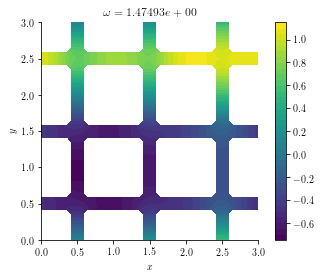

In [6]:
def PlotSolution(u):
    '''
    Creates a figure and axis object for plotting the function u that is passed.
    '''
    fig, ax = plt.subplots(1)
    FigWindowSettings(ax)
    plot(u)
    fig.colorbar(plot(u))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
    return fig, ax
    
w = 1
u = Function(V)
u.vector()[:] = wVecs[:,w]

fig, ax = PlotSolution(u)
ax.set_title(r'$ \omega= %.5e $' % (wVals[w]))
fig.show()